In [1]:
import pint
class ScmUnitRegistry(pint.UnitRegistry):  # type: ignore
    """
    Unit registry class for OpenSCM. Provides some convenience methods to add standard
    unit and contexts.
    """

    _contexts_loaded: bool = False

    def add_standards(self):
        """
        Add standard units.
        Has to be done separately because of pint's weird initializing.
        """
#        self._add_gases(_standard_gases)

        self.define("a = 1 * year = annum = yr")
        self.define("h = hour")
        self.define("d = day")
#        self.define("degreeC = degC")
#        self.define("degreeF = degF")
        self.define("kt = 1000 * t")  # since kt is used for "knot" in the defaults
    
        self.define('volume_mixing_ratio = [vmr] = vmr')
        self.define('parts_per_million = 1e-6 * volume_mixing_ratio = ppm')
        self.define('parts_per_billion = 1e-9 * volume_mixing_ratio = ppb')
        self.define('parts_per_trillion = 1e-12 * volume_mixing_ratio = ppt')

In [35]:
# from openscm.units import _unit_registry as unit
# #unit = ScmUnitRegistry()
# kt = unit("kt")
# unit('kt')

1 <Unit('kt')>

In [4]:
import numpy as np
from fair.constants.general import M_ATMOS
from fair.constants.molwt import AIR as M_AIR   # this will be moved
from fair.constants import molwt
import pint

unit = pint.UnitRegistry()
#unit.add_standards()
unit.define('volume_mixing_ratio = [vmr] = vmr')
unit.define('percent = 0.01 * volume_mixing_ratio = pc')
unit.define('parts_per_million = 1e-6 * volume_mixing_ratio = ppm')
unit.define('parts_per_billion = 1e-9 * volume_mixing_ratio = ppb')
unit.define('parts_per_trillion = 1e-12 * volume_mixing_ratio = ppt')
unit.define('kt = 1000 * t')
unit.define('kilometric_ton = kt')
emissions = 10 * unit.kt / unit.year
M_ATM = M_ATMOS * unit.kg
m_ch4 = molwt.CH4 * unit.g / unit.mol
M_AIR = molwt.AIR * unit.g / unit.mol
timestep = 1 * unit.year

print(emissions)
print(M_ATM)
print(m_ch4, M_AIR)

# this is per year
print((emissions/M_ATM * M_AIR/m_ch4 * unit.year * unit.vmr).to_base_units().to('ppb'))

10.0 kt / year
5.1352e+18 kilogram
16.04 gram / mole 28.97 gram / mole
0.0035171166180203023 parts_per_billion


In [13]:
library = ['CO2', 'CH4', 'N2O']

class Species:
 
    def __init__(self, name=None, efficacy=1):
        self.name = name
        self.efficacy = efficacy
        
        #if name in library:   # pandas datatable of stats or a csv?
            # load up all the stuff above
            # self.lifetime = library[name].lifetime
            # self.radiative_efficiency = library[name].radiative_efficiency and so on
    
    def set_emissions(self, anthropogenic, natural=0, timestep=unit.year):
        self.emissions = anthropogenic
        self.natural_emissions = natural
        self.timestep = timestep
        return Emissions(anthropogenic, natural, timestep)
    
    def set_concentrations(self):
        return Concentrations()
        
    def set_lifetime(self, lifetime):
        self.lifetime = lifetime
        
    def calculate_concentrations(self):
        # for GHGs with no temperature feedback or inter-species dependence
        emissions = self.emissions + self.natural_emissions
        nt = len(emissions)   # ensures that either emissions or natural_emissions are array - still need to check it is 1D
        concentrations = np.ones(nt+1) * np.nan * unit.vmr

        def _forward(c0, em, ts, lt, vm):   # put this in its own module and import
            c1 = c0*np.exp(-ts/lt) + lt*em*vm * (1.-np.exp(-ts/lt))
            return c1
            
        concentrations[0] = self.concentration_t0
        
        for t in range(nt):
            concentrations[t+1] = _forward(concentrations[t], emissions[t], 
                                         timestep, self.lifetime, self.kg_to_vmr)

        self.concentrations = concentrations
        return Concentrations(concentrations)

    def calculate_forcing(self, scale=1):
        # need checks to determine that scale is scalar or array with same length as 
        self.radiative_forcing = (self.concentrations - self.reference_concentration) * self.radiative_efficiency * scale
        self.radiative_forcing.ito(unit.watt / unit.m**2)
        return RadiativeForcing(self.radiative_forcing)

    
class GreenhouseGas(Species):
    def __init__(self, radiative_efficiency, reference_concentration, concentration_t0, molecular_weight):
        self.radiative_efficiency    = radiative_efficiency
        self.reference_concentration = reference_concentration
        self.concentration_t0        = concentration_t0
        self.molecular_weight        = molecular_weight
        self.kg_to_vmr               = M_AIR/self.molecular_weight / M_ATM * 1.0 * unit.vmr
    
        
class Emissions:
    def __init__(self, anthropogenic, natural, timestep):
        self.emissions=anthropogenic
        self.natural_emissions=natural
        self.timestep=timestep
        
        
class Concentrations:
    def __init__(self, concentrations):
        self.concentrations = concentrations
    
    
class RadiativeForcing:
    def __init__(self, radiative_forcing):
        self.radiative_forcing = radiative_forcing
        
        
class Temperature:
    def __init__(self):
        pass

In [20]:
CFC12 = GreenhouseGas(radiative_efficiency=0.32 * unit.watt / unit.m**2 / unit.ppb,
                   reference_concentration=0 * unit.ppt,
                   concentration_t0=0 * unit.ppt,
                   molecular_weight=120.91 * unit.g / unit.mol)
CFC12.set_emissions(np.ones(1000)*500 * unit.kt / unit.year,
                  natural = 0.00 * unit.kt / unit.year)
CFC12.set_lifetime(100 * unit.years)
CFC12.calculate_concentrations()

In [21]:
kiloton = 1*unit.kt
kiloton.check('[mass]')

True

In [22]:
unit.Mt

<Unit('megametric_ton')>

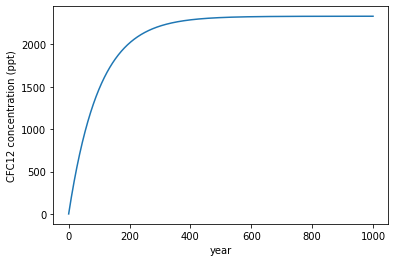

In [23]:
%matplotlib inline
import matplotlib.pyplot as pl
years = np.arange(1001) * unit.year
pl.plot(years, CFC12.concentrations.to('ppt'))
pl.xlabel('year')
pl.ylabel('CFC12 concentration (ppt)');

In [7]:
CFC12.calculate_forcing()

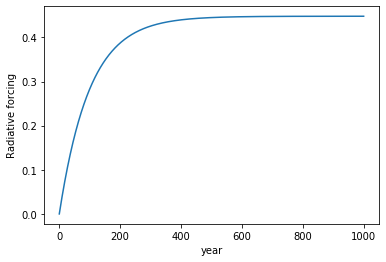

In [8]:
pl.plot(years, CFC12.radiative_forcing.to('W/m**2'))
pl.xlabel('year')
pl.ylabel('Radiative forcing');

Text(0, 0.5, 'temperature')

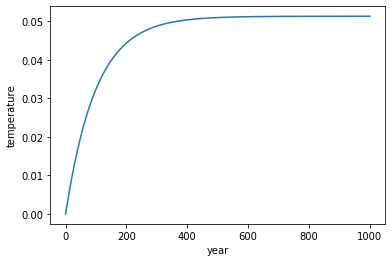

In [9]:
# this I think is currently wrong but has not been followed through fully from fair 1.0 - just illustrative
def calculate_temperature(radiative_forcing,
                          efficacy=1,
                          d=np.array([239, 4.1]) * unit.year,
                          q=np.array([0.33,0.41]) * unit.K * unit.m**2 / unit.watt,
                          timestep = 1 * unit.year
                         ):
    # radiative forcing needs to be smartly handled here
    # radiative_forcing = sum_over_all_species_forcing
    nbox = len(q)
    nt = len(radiative_forcing)
    T_j = np.ones((nt, nbox)) * np.nan * unit.K
    T   = np.ones((nt)) * np.nan * unit.K
    
    # Update the thermal response boxes
    T_j[0,:] = (q/d)*radiative_forcing[0] * efficacy * timestep

    # Sum the thermal response boxes to get the total temperature anomaly
    T[0]=np.sum(T_j[0,:],axis=-1)
    
    for t in range(1,nt):
        # Update the thermal response boxes
        T_j[t,:] = T_j[t-1,:]*(1 - np.exp(-timestep/d)) + q * (1-np.exp((-timestep)/d)) * radiative_forcing[t] * efficacy
        # Sum the thermal response boxes to get the total temperature
        T[t]=np.sum(T_j[t,:],axis=-1)
    return T
        
T = calculate_temperature(CFC12.radiative_forcing)
pl.plot(years, T)
pl.xlabel('year')
pl.ylabel('temperature')

In [25]:
import pint
ureg = pint.UnitRegistry()
del ureg.knot

AttributeError: knot

In [26]:
fair.__version__

'1.4+3.g52e1df7.dirty'

In [25]:
import fair